# Evals oxygen in Penn Cove - 2022

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm as cm

In [2]:
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
    tmask0 = mesh.tmask
    mbathy0 = mesh.mbathy
    long = mesh.nav_lon
    latg = mesh.nav_lat
with xr.open_dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc') as bath:
    bathy = bath.Bathymetry

In [3]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
        shift_text = 0.94
    else:
        print (temp1.keys())
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth) & (temp1[obsn] == temp1[obsn])]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 



def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1


In [4]:
def stats_and_plot(years, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_from_KC_{year}0101_{year}1231.csv')
              #f'/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_ctd_from_UW_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    alltogether, counts = plot_and_stats(temp1, '202111', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)


    pieces2 = []
    for year in years:
        pieces2.append(
              f'/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_from_KC_{year}0101_{year}1231.csv')
              #f'/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_ctd_from_UW_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202410, counts = plot_and_stats(temp2, '202410', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)

    alltogether = pd.concat([alltogether, d202410], axis=0)

In [5]:


def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
    ks = (select.groupby('k')[obsn].mean().index[:])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[ks], 'o-', c='k', label='Obs')
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:red', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:red', label='202111')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:red')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:red')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3]) &
                              (temp2[obsn] == temp2[obsn])]
    #ks = (select.groupby('k')[obsn].mean().index[:])
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:blue', label='202410')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:blue', label='202410')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax.fill_betweenx(deptht[ks], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='k')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [15]:
d202111_22 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_from_KC_20220101_20221231.csv')
d202410_22 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_from_KC_20220101_20221231.csv')

In [7]:
from pathlib import Path
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
lon1, lon2 = (-122.75, -122.6)
lat1, lat2 = (48.15, 48.32)
jg11 = grid_lons_lats.jj.sel(lats=lat1, lons=lon1, method='nearest')
ig11 = grid_lons_lats.ii.sel(lats=lat1, lons=lon1, method='nearest')
jg12 = grid_lons_lats.jj.sel(lats=lat1, lons=lon2, method='nearest')
ig12 = grid_lons_lats.ii.sel(lats=lat1, lons=lon2, method='nearest')
jg21 = grid_lons_lats.jj.sel(lats=lat2, lons=lon1, method='nearest')
ig21 = grid_lons_lats.ii.sel(lats=lat2, lons=lon1, method='nearest')
jg22 = grid_lons_lats.jj.sel(lats=lat2, lons=lon2, method='nearest')
ig22 = grid_lons_lats.ii.sel(lats=lat2, lons=lon2, method='nearest')

jjS1 = grid_lons_lats.jj.sel(lats=48.2300, lons=-122.670, method='nearest')
iiS1 = grid_lons_lats.ii.sel(lats=48.2300, lons=-122.670, method='nearest')
jjCW = grid_lons_lats.jj.sel(lats=48.2230, lons=-122.688, method='nearest')
iiCW = grid_lons_lats.ii.sel(lats=48.2230, lons=-122.688, method='nearest')
jjEN = grid_lons_lats.jj.sel(lats=48.2370, lons=-122.655, method='nearest')
iiEN = grid_lons_lats.ii.sel(lats=48.2370, lons=-122.655, method='nearest')
jjWS = grid_lons_lats.jj.sel(lats=48.2249, lons=-122.720, method='nearest')
iiWS = grid_lons_lats.ii.sel(lats=48.2249, lons=-122.720, method='nearest')


/tmp/ipykernel_3793321/858484391.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=200)
/tmp/ipykernel_3793321/858484391.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im=ax[1].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=300)


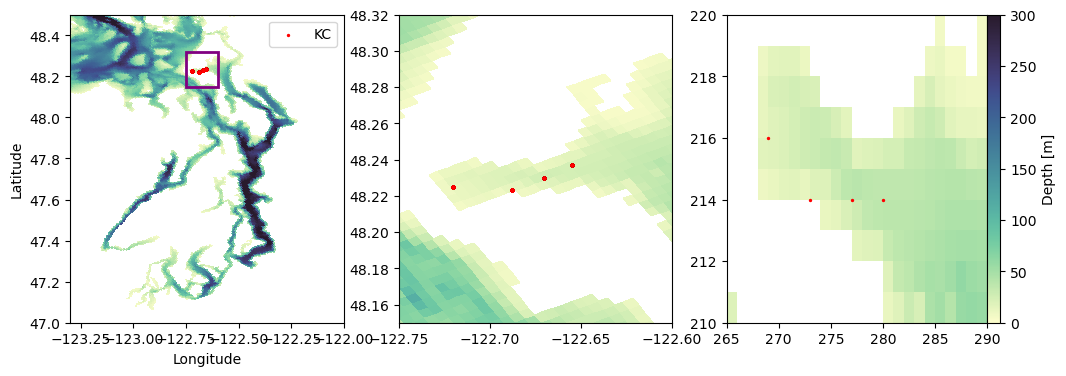

In [64]:
fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=200)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_ylim([47,48.5])
ax[0].set_xlim([-123.3,-122])
# plot the location of observations
ax[0].scatter(d202111_22.Lon, d202111_22.Lat, color='r', s=2, label="KC")
ax[0].legend()
left, bottom, width, height = (lon2, lat1, lon1-lon2, lat2-lat1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                    fill=False,
                    color="purple",
                    linewidth=2,
                    label="Puget Sound")
  
ax[0].add_patch(rect)
im=ax[1].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=300)
ax[1].set_ylim([lat1,lat2])
ax[1].set_xlim([lon1,lon2])
ax[1].scatter(d202111_22.Lon, d202111_22.Lat, color='r', s=2, label="KC")


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.002)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Depth [m]')



ax[2].pcolormesh(bathy, cmap=cm.deep, vmin=0, vmax=200)
ax[2].set_ylim([210,220])
ax[2].set_xlim([265,290])
# plot the location of observations
ax[2].scatter(iiS1, jjS1, color='r', s=2)
ax[2].scatter(iiCW, jjCW, color='r', s=2)
ax[2].scatter(iiEN, jjEN, color='r', s=2)
ax[2].scatter(iiWS, jjWS, color='r', s=2)


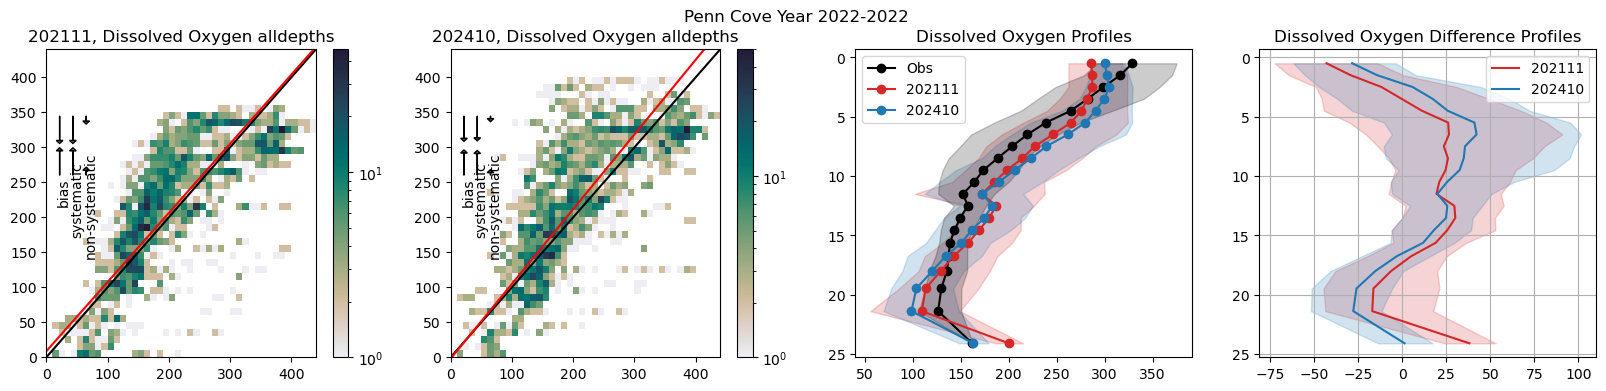

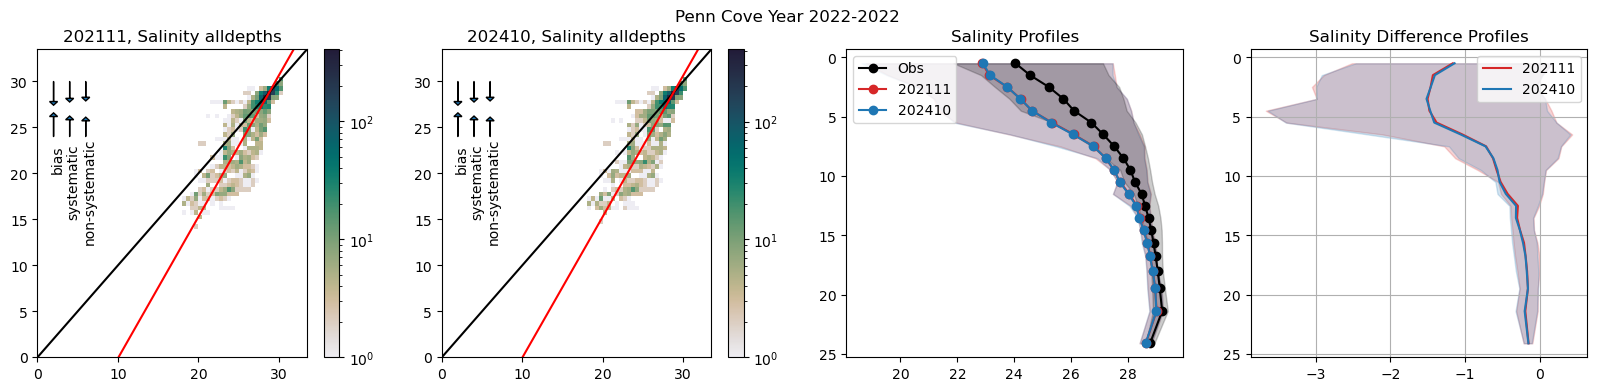

In [ ]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'
Penn_Cove = [210, 220, 265, 290]
idepth = 0
jdepth = 39

field = 'Dissolved Oxygen'
obsn = 'Oxygen_Dissolved'
modn = 'mod_dissolved_oxygen'
vmax = 450
vmin = 0
dbin = 10
scale = 260
stats_and_plot([2022],
               idepth, jdepth, Penn_Cove, 'Penn Cove', 'alldepths')

field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

stats_and_plot([2022],
               idepth, jdepth, Penn_Cove, 'Penn Cove', 'alldepths')

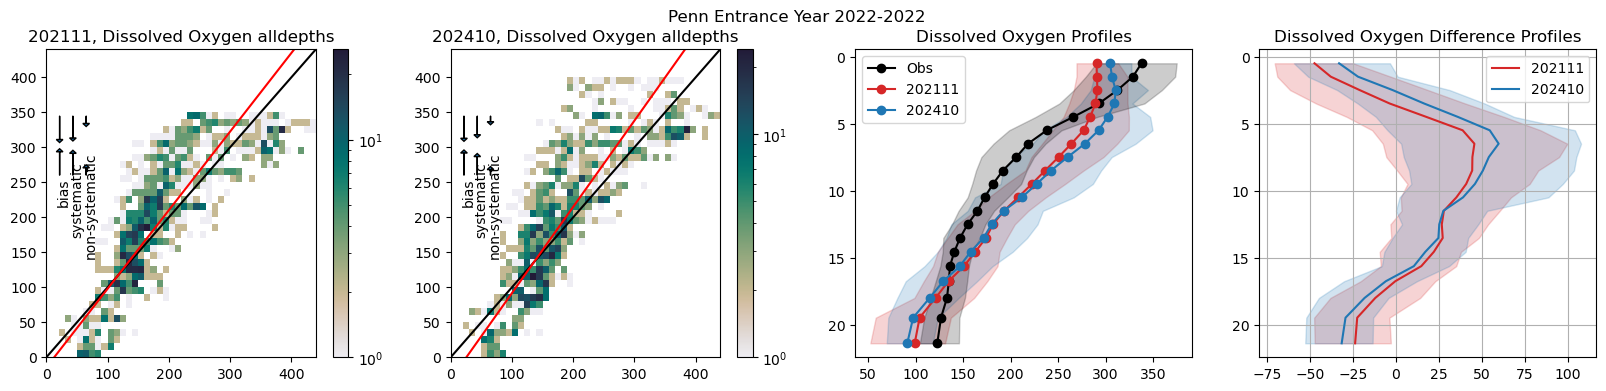

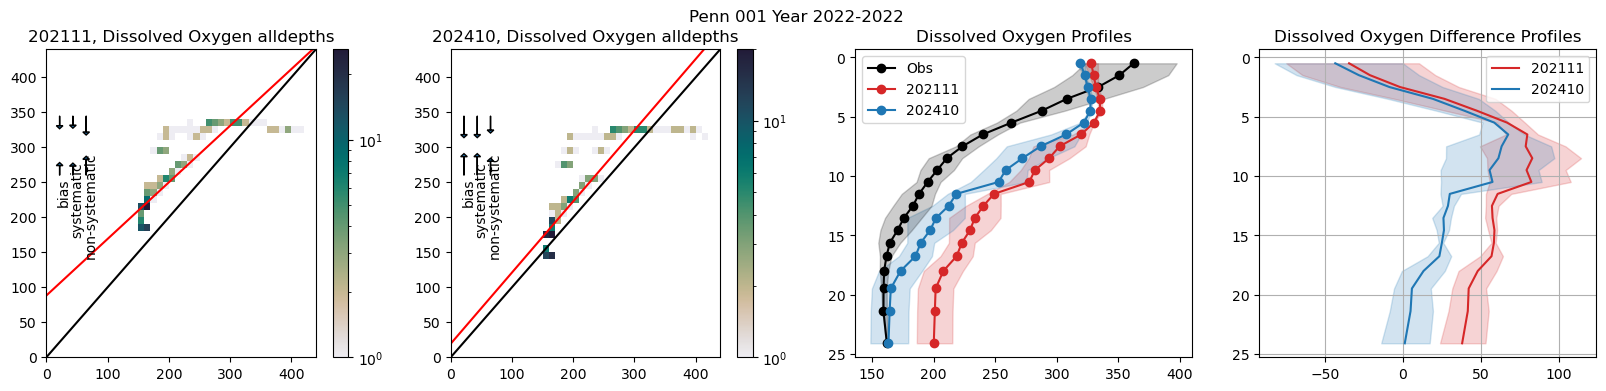

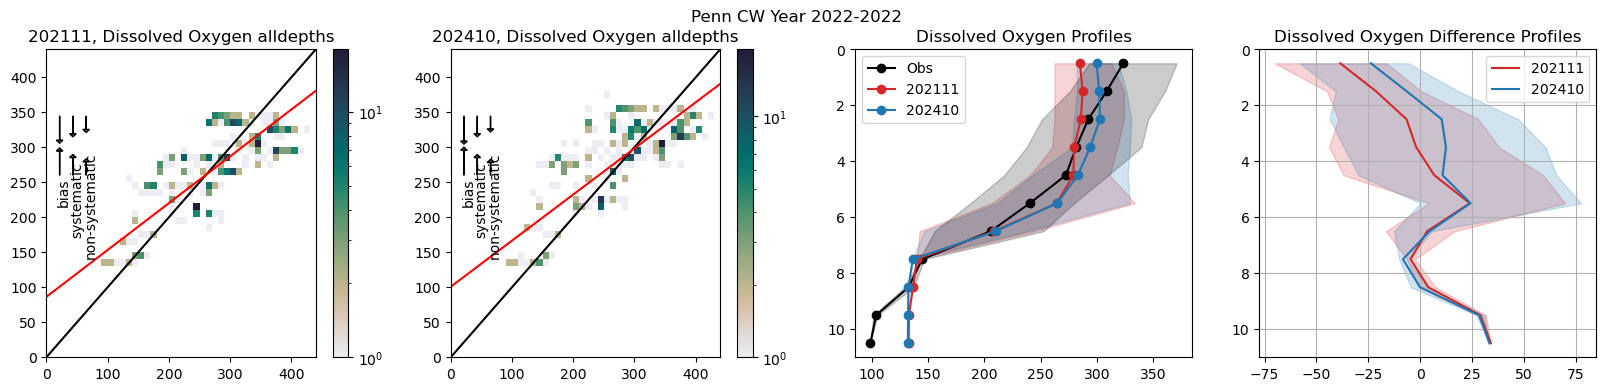

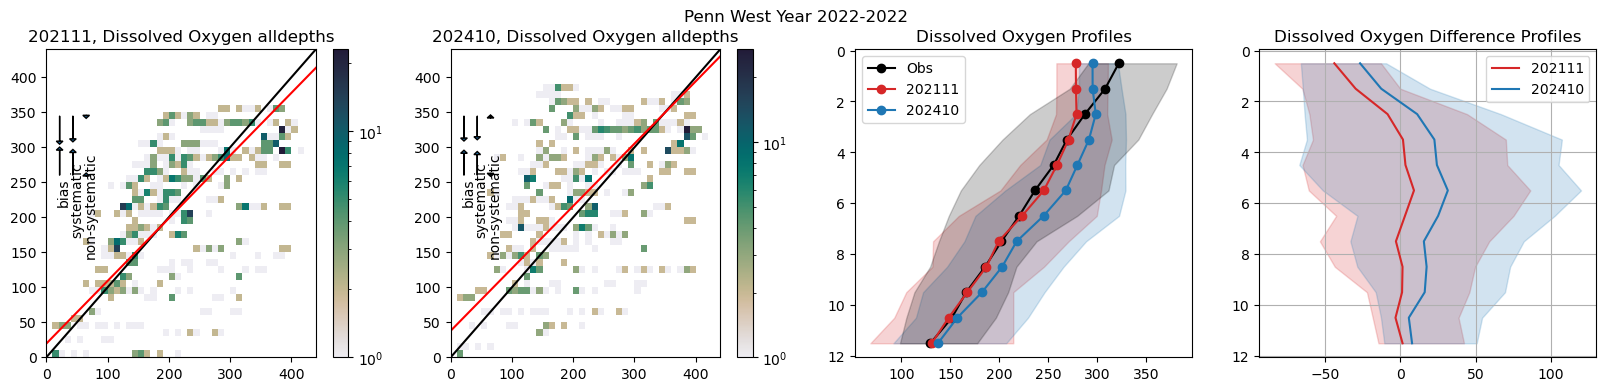

In [66]:
Entrance = [210, 220, 278, 290]
PENN001 = [210, 220, 275, 278]
PENNCW = [210, 220, 271, 275]
PENNWEST = [210, 220, 210, 271]

idepth = 0
jdepth = 39

field = 'Dissolved Oxygen'
obsn = 'Oxygen_Dissolved'
modn = 'mod_dissolved_oxygen'
vmax = 450
vmin = 0
dbin = 10
scale = 260
stats_and_plot([2022],
               idepth, jdepth, Entrance, 'Penn Entrance', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENN001, 'Penn 001', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENNCW, 'Penn CW', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENNWEST, 'Penn West', 'alldepths')


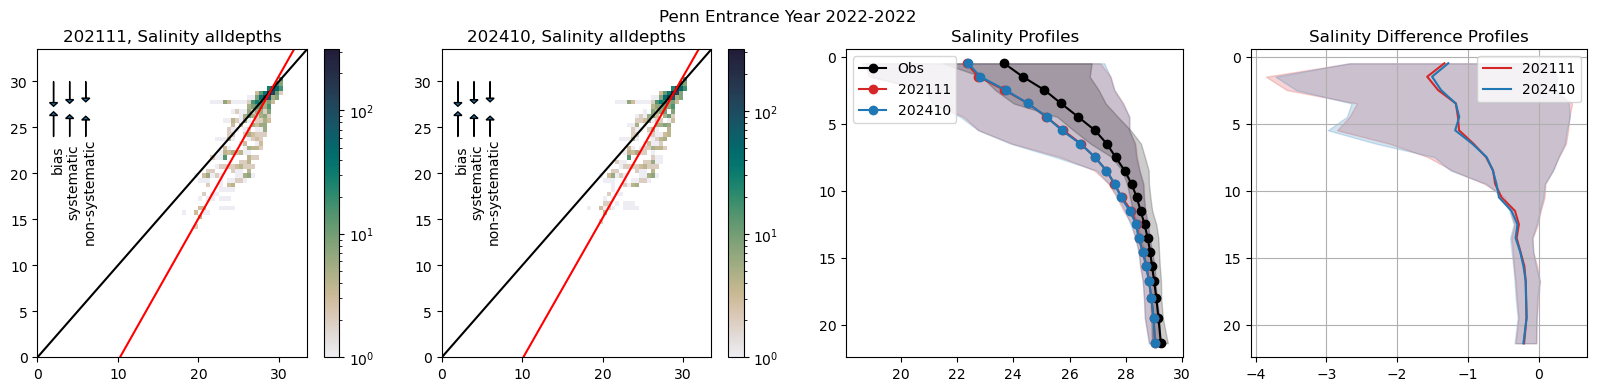

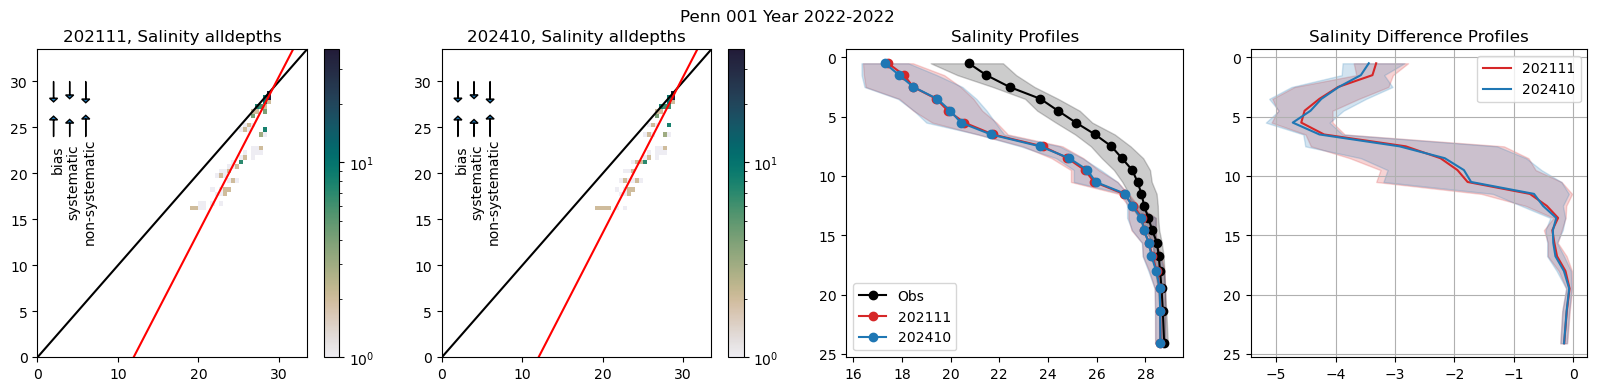

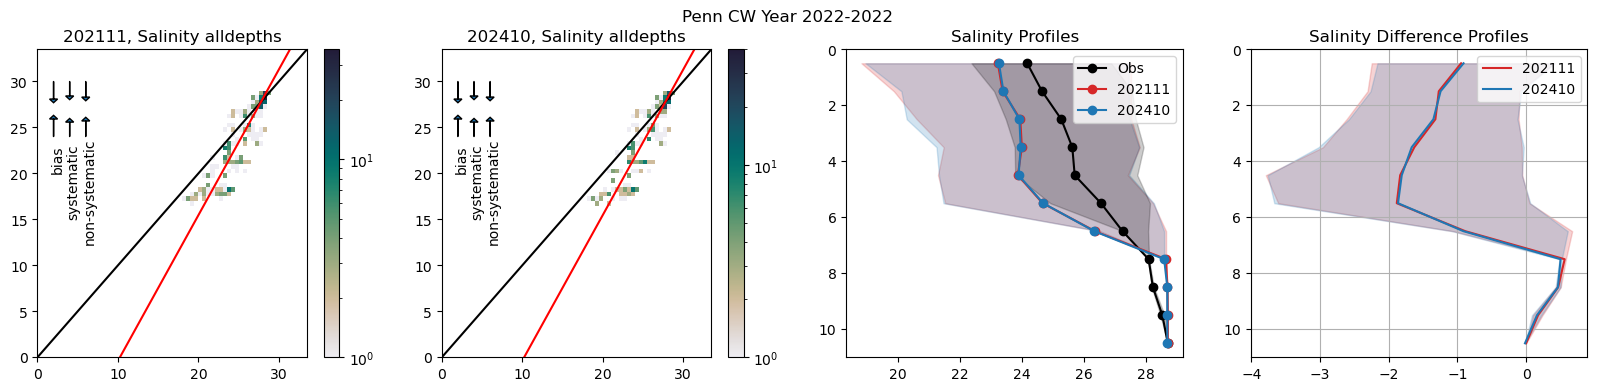

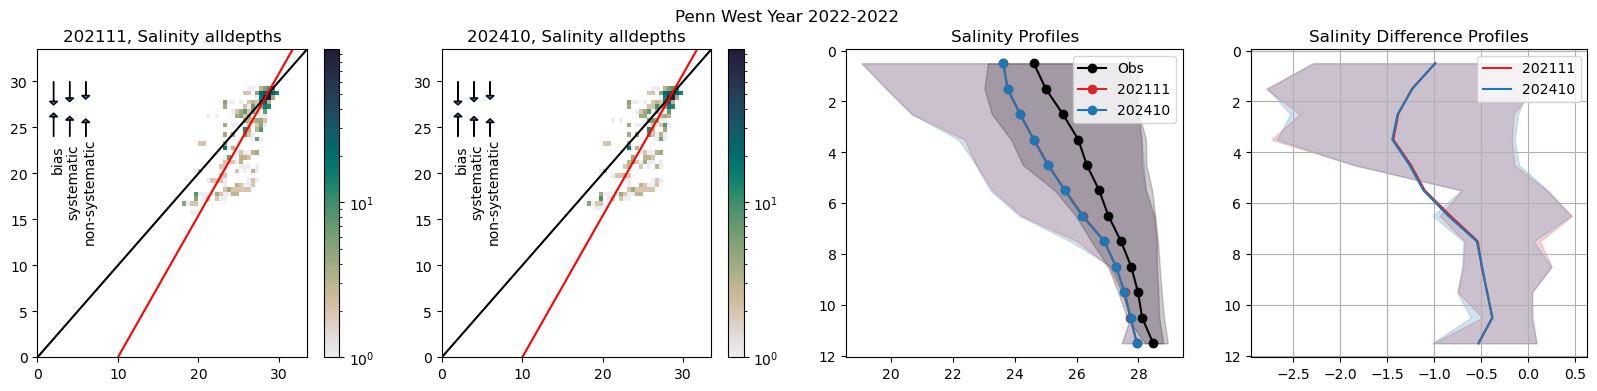

In [67]:
Entrance = [210, 220, 278, 290]
PENN001 = [210, 220, 275, 278]
PENNCW = [210, 220, 271, 275]
PENNWEST = [210, 220, 210, 271]

idepth = 0
jdepth = 39

field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24
stats_and_plot([2022],
               idepth, jdepth, Entrance, 'Penn Entrance', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENN001, 'Penn 001', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENNCW, 'Penn CW', 'alldepths')
stats_and_plot([2022],
               idepth, jdepth, PENNWEST, 'Penn West', 'alldepths')


[Text(0.0, 0, 'Start'), Text(3173.0, 0, 'End')]

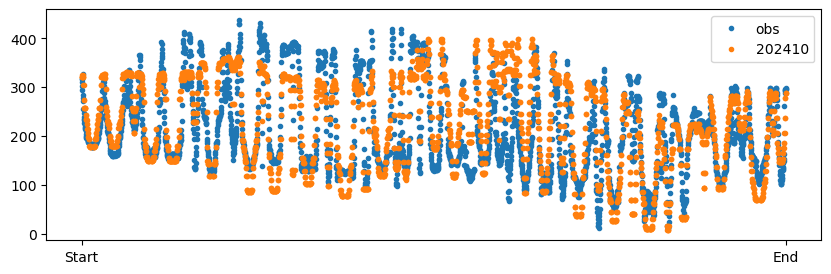

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

import matplotlib.dates as mdates
half_year_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.plot(d202410_22.dtUTC, d202111_22.Oxygen_Dissolved, '.',label='obs')
ax.plot(d202410_22.dtUTC, d202410_22.mod_dissolved_oxygen,'.',label='202410')
ax.legend()
ax.set_xticks([d202410_22.dtUTC.iloc[0], d202410_22.dtUTC.iloc[-1]])
ax.set_xticklabels(['Start', 'End'])

[Text(0.0, 0, 'Start'), Text(3173.0, 0, 'End')]

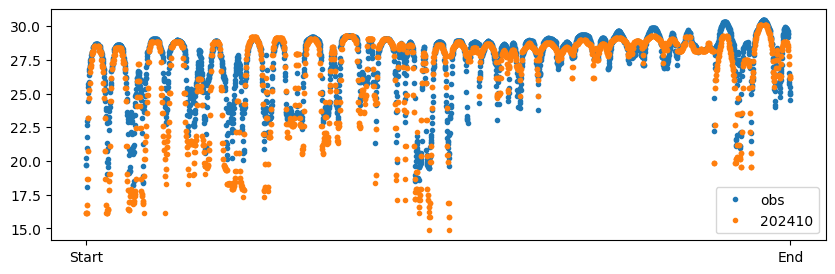

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

import matplotlib.dates as mdates
half_year_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.plot(d202410_22.dtUTC, d202111_22.SA, '.',label='obs')
ax.plot(d202410_22.dtUTC, d202410_22.mod_vosaline,'.',label='202410')
ax.legend()
ax.set_xticks([d202410_22.dtUTC.iloc[0], d202410_22.dtUTC.iloc[-1]])
ax.set_xticklabels(['Start', 'End'])

In [23]:
d202410_22["time"] = pd.to_datetime(d202410_22["dtUTC"])

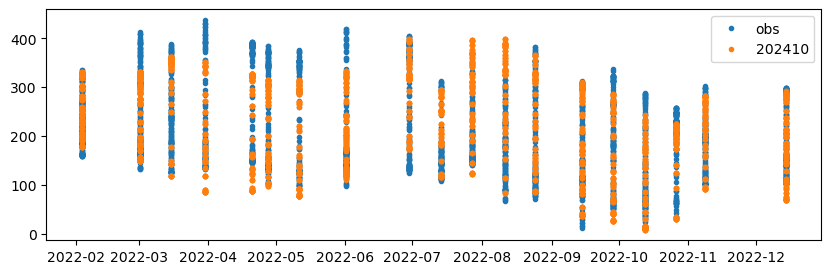

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time, d202111_22.Oxygen_Dissolved, '.',label='obs')
ax.plot(d202410_22.time, d202410_22.mod_dissolved_oxygen,'.',label='202410')
ax.legend()

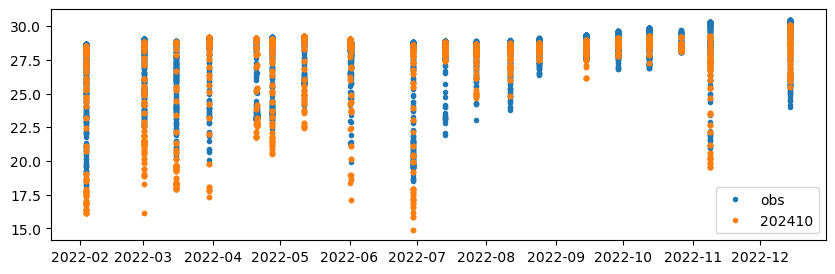

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time, d202111_22.SA, '.',label='obs')
ax.plot(d202410_22.time, d202410_22.mod_vosaline,'.',label='202410')
ax.legend()

Text(0.5, 1.0, 'PENN COVE-WEST')

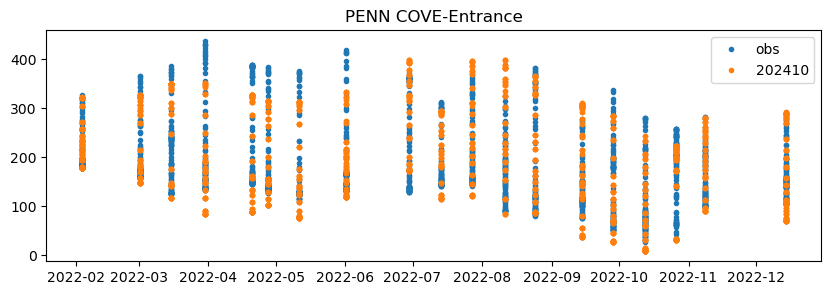

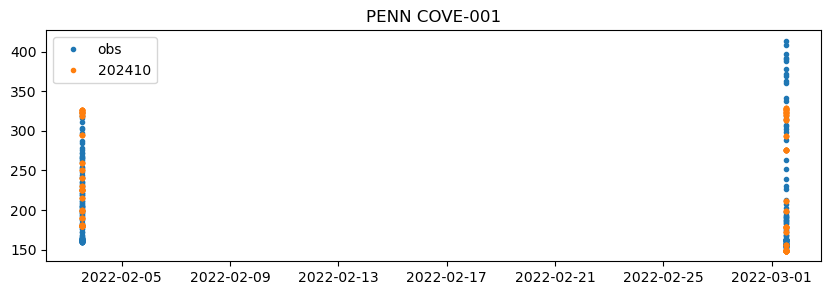

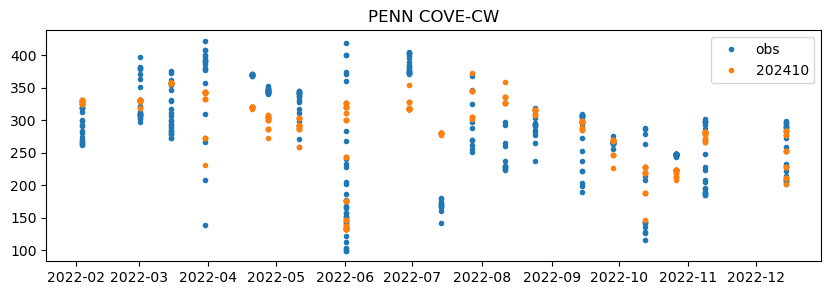

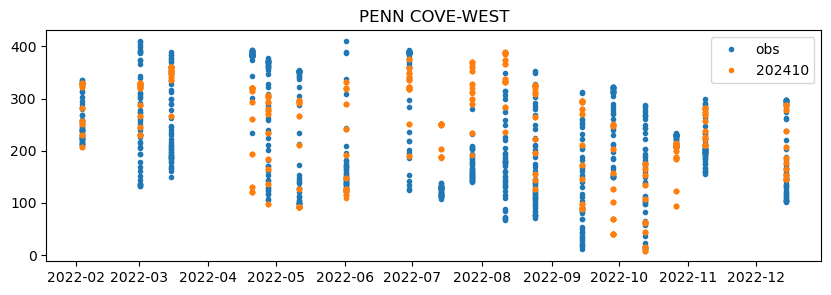

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEENT'), d202111_22.Oxygen_Dissolved.where(d202410_22.Locator=='PENNCOVEENT'), '.',label='obs')
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEENT'), d202410_22.mod_dissolved_oxygen.where(d202410_22.Locator=='PENNCOVEENT'),'.',label='202410')
ax.legend()
ax.set_title('PENN COVE-Entrance')
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEPNN001'), d202111_22.Oxygen_Dissolved.where(d202410_22.Locator=='PENNCOVEPNN001'), '.',label='obs')
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEPNN001'), d202410_22.mod_dissolved_oxygen.where(d202410_22.Locator=='PENNCOVEPNN001'),'.',label='202410')
ax.legend()
ax.set_title('PENN COVE-001')
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVECW'), d202111_22.Oxygen_Dissolved.where(d202410_22.Locator=='PENNCOVECW'), '.',label='obs')
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVECW'), d202410_22.mod_dissolved_oxygen.where(d202410_22.Locator=='PENNCOVECW'),'.',label='202410')
ax.legend()
ax.set_title('PENN COVE-CW')
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEWEST'), d202111_22.Oxygen_Dissolved.where(d202410_22.Locator=='PENNCOVEWEST'), '.',label='obs')
ax.plot(d202410_22.time.where(d202410_22.Locator=='PENNCOVEWEST'), d202410_22.mod_dissolved_oxygen.where(d202410_22.Locator=='PENNCOVEWEST'),'.',label='202410')
ax.legend()
ax.set_title('PENN COVE-WEST')